# ASR Dataset Quality Evaluation - Common Voice 23.0

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://datacollective.mozillafoundation.org/datasets/cmflnuzw7fd2f0vzknodytok4). You can find more information about the structure of the dataset [here](https://github.com/common-voice/cv-dataset). Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import os

import pandas as pd

from scripts.uzbek_text_normalizer import normalize_text

DATASET_DIR = "../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz"
CUSTOM_VALIDATED_CSV_PATH = os.path.join(DATASET_DIR, "custom_validated.csv")
ALL_DATA_CSV_PATH = os.path.join(DATASET_DIR, "all_data.csv")
SAMPLED_RECORDINGS_PATH = os.path.join(DATASET_DIR, "sampled_recordings.csv")

COLUMNS_TO_DROP = ["sentence_domain", "accents", "variant", "locale", "segment"]

### Create csv file with all data and computed statistics

In [2]:
import csv


def load_data_from_tsv(tsv_path: str) -> pd.DataFrame:
    """Load data from given tsv file with Common Voice specific configurations."""
    return pd.read_csv(
        tsv_path,
        sep="\t",
        quoting=csv.QUOTE_NONE,
        # Important: Common Voice doesn't use quotes at all (yet, pandas default quoting is csv.QUOTE_MINIMAL)
        dtype={"accent": str},
        low_memory=False,
        # Fix the mixed type warning
    )

In [3]:
# Load and combine split data (train.tsv, dev.tsv, test.tsv)
splits = []
for split_name in ["train", "dev", "test"]:
    split_tsv_file = os.path.join(DATASET_DIR, f"{split_name}.tsv")
    df = load_data_from_tsv(split_tsv_file)
    df["type"] = split_name
    splits.append(df)

combined_df = pd.concat(splits, ignore_index=True)

# Load additional validated data that's not already in the custom validated set
validated_df = load_data_from_tsv(os.path.join(DATASET_DIR, "validated.tsv"))
additional_validated_df = validated_df[~validated_df["path"].isin(combined_df["path"])].copy()

# Add additional data to train set
additional_validated_df["type"] = "train"
custom_validated_df = pd.concat([combined_df, additional_validated_df], ignore_index=True)
print(f"Total number of validated entries: {len(custom_validated_df)}")

Total number of validated entries: 87103


In [4]:
def load_clip_durations(dataset_dir: str) -> dict:
    """Load clip durations and return as a dictionary."""
    clip_durations_df = pd.read_csv(os.path.join(dataset_dir, "clip_durations.tsv"), sep="\t")
    clip_durations_df["duration"] = clip_durations_df["duration[ms]"] / 1000
    clip_durations_df.drop(columns=["duration[ms]"], inplace=True)

    return (
        clip_durations_df
        .set_index("clip")["duration"]
        .to_dict()
    )


def prepare_final_data(df: pd.DataFrame, dataset_dir: str, output_csv_file_name: str = "output.csv") -> pd.DataFrame:
    """
    Drop unnecessary columns, add clip durations and word count columns, normalize transcription text, save the result to csv file.
    """
    # Remove unnecessary columns
    df.drop(
        columns=COLUMNS_TO_DROP,
        inplace=True,
    )

    # Remove rows with sentence is None or whitespace only
    df = df[df["sentence"].notna() & (df["sentence"].str.strip() != '')]

    # Add clip durations
    clip_duration_dict = load_clip_durations(dataset_dir)
    df["duration"] = df["path"].map(clip_duration_dict)

    # Add word count
    df["word_count"] = df["sentence"].str.split().str.len()

    # Normalize transcription text
    df["sentence"] = df["sentence"].apply(normalize_text)

    # Save result
    output_csv_path = os.path.join(dataset_dir, output_csv_file_name)
    print(f"Saving to {output_csv_path}...")
    df.to_csv(output_csv_path, index_label="id")

    print(f"✓ Processing complete. Total records: {len(df)}")
    return df


# Final data preparation (drop and add columns, normalize transcription text, save the results to csv)
prepare_final_data(custom_validated_df, DATASET_DIR, output_csv_file_name="custom_validated.csv")

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/custom_validated.csv...
✓ Processing complete. Total records: 87103


,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count
0,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907218.mp3,bc07db8b7a00a0b99d7c0ef267d1de330e807c9810eef6...,Bugun ertalab Gyotenikiga taklifnoma oldim.,2,0,twenties,male_masculine,train,4.788,5
1,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907221.mp3,a6530f96b764bd5571b024ea38e448df2deae123e522f0...,Uning badiiy tasvir imkoniyatlarini rivojlanti...,2,0,twenties,male_masculine,train,5.076,5
2,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907226.mp3,c1a227e11d003ffe07a9b86850637ae0e4adfb1351ae72...,Udan ko'ra balandroq joy bor.,2,1,twenties,male_masculine,train,4.140,5
3,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907243.mp3,bb64eb96e0ce5f555cc8d3420687b9b4079165003999ed...,Bu jumlada fig'oni falakka chiqib birikmasi ib...,2,1,twenties,male_masculine,train,7.560,12
4,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907245.mp3,85a5fea3c41d39bcfe0ea6c75b1a1ea7fd9395aeed064b...,Bundan tashqari puxta jamlangan kutubxona bor.,2,1,twenties,male_masculine,train,5.436,6
...,...,...,...,...,...,...,...,...,...,...,...
87098,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299258.mp3,c6db057a9f4390f5eba23152931ed21106e23267701694...,Ikki,2,0,twenties,female_feminine,train,1.548,1
87099,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299279.mp3,c70f4b9db0b02db22056d4ef5a1c8cf9eb5c6c82ea0499...,U boshqa kasb etagini tutsin.,2,0,twenties,female_feminine,train,2.736,5
87100,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299677.mp3,c8f9a9bdaf43fed1bbd5db7c049ecce6601520eb54cc53...,Quyosh ham tolib oyog'i,2,0,twenties,female_feminine,train,2.340,4
87101,30fd02023d452dbd8d83510cf487aabca11a7138c6245b...,common_voice_uz_30299721.mp3,c8bc1507705991a9552dc11f3e507f984161a35ffb1bb5...,"Sizga, olavering. Chakkangiz og'riganda kerak ...",2,0,twenties,female_feminine,train,3.960,6


In [5]:
custom_validated_df = pd.read_csv(CUSTOM_VALIDATED_CSV_PATH, index_col="id")

print(custom_validated_df.info())
print(custom_validated_df.describe())
print("\nFirst few rows:")
custom_validated_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 87103 entries, 0 to 87102
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   client_id    87103 non-null  object 
 1   path         87103 non-null  object 
 2   sentence_id  87103 non-null  object 
 3   sentence     87103 non-null  object 
 4   up_votes     87103 non-null  int64  
 5   down_votes   87103 non-null  int64  
 6   age          47537 non-null  object 
 7   gender       48096 non-null  object 
 8   type         87103 non-null  object 
 9   duration     87103 non-null  float64
 10  word_count   87103 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 8.0+ MB
None
           up_votes    down_votes      duration    word_count
count  87103.000000  87103.000000  87103.000000  87103.000000
mean       2.015602      0.185034      4.396574      6.325236
std        0.153555      0.390950      1.539892      2.657401
min        2.000000      0.000000  

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count
id,,,,,,,,,,,
0,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907218.mp3,bc07db8b7a00a0b99d7c0ef267d1de330e807c9810eef6...,Bugun ertalab Gyotenikiga taklifnoma oldim.,2,0,twenties,male_masculine,train,4.788,5
1,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907221.mp3,a6530f96b764bd5571b024ea38e448df2deae123e522f0...,Uning badiiy tasvir imkoniyatlarini rivojlanti...,2,0,twenties,male_masculine,train,5.076,5
2,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907226.mp3,c1a227e11d003ffe07a9b86850637ae0e4adfb1351ae72...,Udan ko'ra balandroq joy bor.,2,1,twenties,male_masculine,train,4.140,5
3,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907243.mp3,bb64eb96e0ce5f555cc8d3420687b9b4079165003999ed...,Bu jumlada fig'oni falakka chiqib birikmasi ib...,2,1,twenties,male_masculine,train,7.560,12
4,2160561702bac0e2048d2dc79810c2d8a6e6942a6dcac8...,common_voice_uz_28907245.mp3,85a5fea3c41d39bcfe0ea6c75b1a1ea7fd9395aeed064b...,Bundan tashqari puxta jamlangan kutubxona bor.,2,1,twenties,male_masculine,train,5.436,6


In [6]:
other_df = load_data_from_tsv(os.path.join(DATASET_DIR, "other.tsv"))
other_df["type"] = "other"
other_df = prepare_final_data(other_df, DATASET_DIR, "other.csv")

invalidated_df = load_data_from_tsv(os.path.join(DATASET_DIR, "invalidated.tsv"))
invalidated_df["type"] = "invalidated"
invalidated_df = prepare_final_data(invalidated_df, DATASET_DIR, "invalidated.csv")

all_data_df = pd.concat([custom_validated_df, other_df, invalidated_df], ignore_index=True)
print(f"Saving to {ALL_DATA_CSV_PATH}...")
all_data_df.to_csv(ALL_DATA_CSV_PATH, index_label="id")
print(f"✓ Processing complete. Total records: {len(all_data_df)}")
all_data_df.info()

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/other.csv...
✓ Processing complete. Total records: 128485


/tmp/ipykernel_14095/128438102.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["duration"] = df["path"].map(clip_duration_dict)
/tmp/ipykernel_14095/128438102.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["word_count"] = df["sentence"].str.split().str.len()
/tmp/ipykernel_14095/128438102.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/invalidated.csv...
✓ Processing complete. Total records: 14116
Saving to ../datasets/mcv-scripted-uz-v23.0/cv-corpus-23.0-2025-09-05/uz/all_data.csv...
✓ Processing complete. Total records: 229704
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229704 entries, 0 to 229703
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    229704 non-null  object 
 1   path         229704 non-null  object 
 2   sentence_id  229704 non-null  object 
 3   sentence     229704 non-null  object 
 4   up_votes     229704 non-null  int64  
 5   down_votes   229704 non-null  int64  
 6   age          135236 non-null  object 
 7   gender       136027 non-null  object 
 8   type         229704 non-null  object 
 9   duration     229704 non-null  float64
 10  word_count   229704 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 19.3+ 

### Dataset statistics plotted

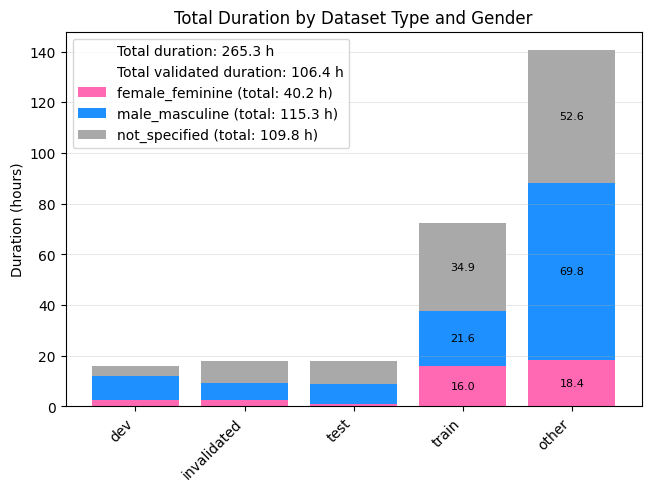

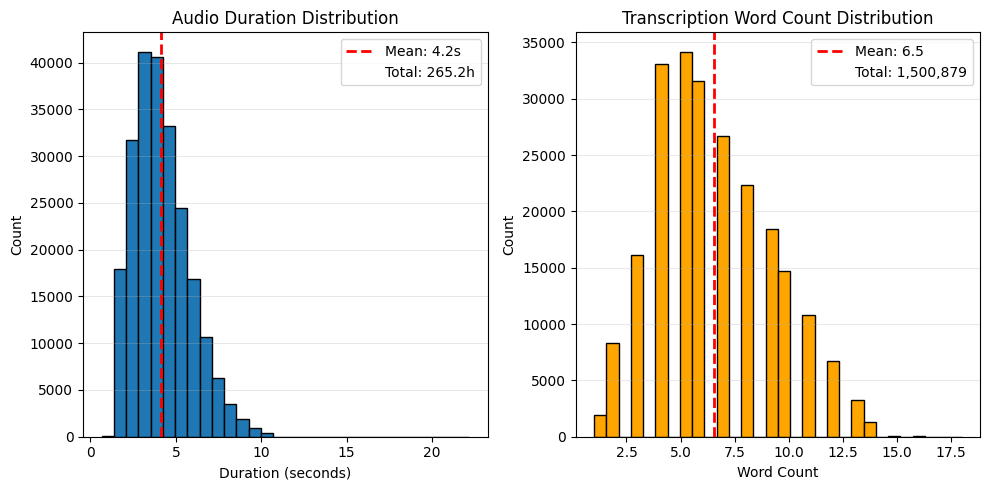

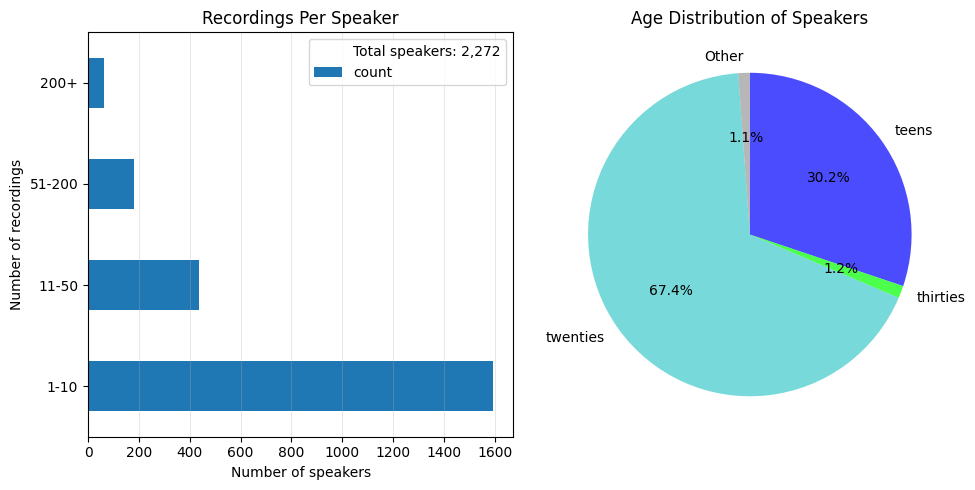

In [7]:
from scripts.dataset_plotting import plot_distribution_graphs, plot_dataset_type_gender_distribution, \
    plot_demographic_statistics, plot_speaker_trust_score_distribution

plot_dataset_type_gender_distribution(all_data_df)
plot_distribution_graphs(all_data_df)
plot_demographic_statistics(all_data_df)

### Calculate speakers' trust score

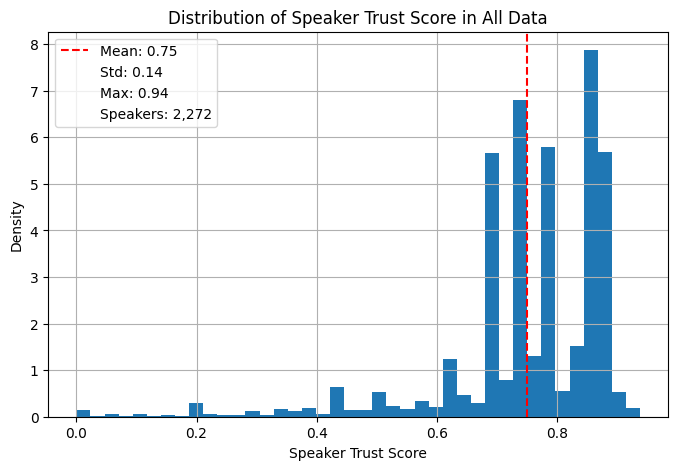

,,up_votes,down_votes,num_recordings
client_id,speaker_trust_score,,,
63c30d8f047df7491379e2bcb6ae54864b35cf1cbd55fd9b0d12a460ea26eb690a699dc540b14b171449ca8d71da92a95ffd22eeef92e04aa18a08c196cd7e43,0.9379,434,18,224
f763d1835e4436a3a85f271bf404cdbcf23f9b9c6f7d4d76772ab58246f52f10b6ea6697e454caa590e7fc49f2d47db547a0d584303e1f113346ab93378d5ef4,0.9375,806,39,404
b5e51f0ffdf226e4c74bc2037bbd9d5a79dbf9660e880f6eb6216f1f9937d172dfda25db5ba2006f18033b83be81e8abf39e0909186eeb7acf41c510dda91d5e,0.9367,109,2,58
44c15c0f726ba78cb2a2f545eebe60e36e997c805e44d1e3672a2e0152f91a9b10a38873c074b7e7efec7d28802e98d0a8ec81e2ba47e9aa8c869a2e68f8fb97,0.9236,126,4,63
b4968971e35c5a65c94480ab31561c7b12ae289bb23e1dade0997e13137c92812e130113f257dc7cf9562bfa11b30a704dfed02cf3fe7d58848214c2cbf5fe34,0.9224,68,1,35
...,...,...,...,...
f679bce4fb519e51f14104a265400e0eea6eafe454420aa7514cf143eded37955ffa2938e608876b200322eef79a3497251670198112e643b0c2eeb3cc2cbecb,0.0000,0,10,5
79295ce47f1be5826e279f29f0779a366a035e8bf77ea3dfdb116a347b8bae95919fb7eac84ea263eab270e9ab00fcffce82a432f3961f1e33330c60bea51857,0.0000,0,1,3
930551688e12393b5a04054f2a877a69c5d347fffed64b1a666f867a22b79595382dc164069e79c516fddd5ed0f0ace394c361ede18b953dec26c23d16cd63f0,0.0000,0,1,10


In [8]:
import scripts.speaker_trust_score

all_data_df = pd.read_csv(ALL_DATA_CSV_PATH, index_col="id")
all_data_df = scripts.speaker_trust_score.trust_score(all_data_df)
all_data_df.to_csv(ALL_DATA_CSV_PATH)

plot_speaker_trust_score_distribution(all_data_df, data_frame_title="All Data")

grouped = (
    all_data_df
    .groupby(["client_id", "speaker_trust_score"])
    .agg({
        "up_votes": "sum",
        "down_votes": "sum",
        "client_id": "count",  # counts recordings per speaker
    })
    .rename(columns={"client_id": "num_recordings"})
)
grouped.sort_values(
    by="speaker_trust_score",
    ascending=False
)

### Extract strategic samples to be checked by Google SPT

From non-validated (i.e. other) set, take longer duration and low trust score samples for check the quality of transcription.

In [9]:
other_df = all_data_df[all_data_df["type"] == "other"].reset_index(drop=True)
other_df.index.name = "id"

other_df_grouped = (
    other_df
    .groupby(["client_id", "speaker_trust_score"])
    .agg({
        "up_votes": "sum",
        "down_votes": "sum",
        "client_id": "count",  # counts recordings per speaker
    })
    .rename(columns={"client_id": "num_recordings"})
).reset_index()

speakers_to_check = other_df_grouped[
    (other_df_grouped["speaker_trust_score"] < 0.75) &
    (other_df_grouped["speaker_trust_score"] > 0.30)
    ]

speakers_to_check = speakers_to_check.sort_values(
    by="num_recordings", ascending=False
).head(300)
speakers_to_check

,client_id,speaker_trust_score,up_votes,down_votes,num_recordings
922,b7808eea20000dd73de504f3d1b545ee8e39025baca405...,0.6816,5097,3731,21593
945,bc69c744bf0f8464394b0554f6d87cc8e1bb9286bf3d13...,0.7333,4494,4189,18740
895,b303b536e41d001670724c7f7902bae04eb218dcb714e1...,0.6494,205,90,980
939,ba6259effb0707163a6a7c2440301ffc466461192eea3a...,0.6181,145,65,581
1002,c83c69afe7f26b08b118c14ca76dfe812177d8acca62ea...,0.7352,92,23,456
...,...,...,...,...,...
121,1ab81b39ba79e347dc49dc60fecc2401504c190abe9ab4...,0.3755,2,1,9
1037,d0c3874f59c5fd3de9294e8093f984a7eac9eb1ea0261c...,0.6097,4,0,9
530,6def659c15a16f52b60189ed75ced6474cc37e98aebabb...,0.7256,0,0,9
352,4b8db9ad0bc8578ff93dc23cb847913a59ee13ee05e4e3...,0.5000,0,0,9


In [10]:
# Filter only these top speakers
speaker_ids = speakers_to_check["client_id"].tolist()
top_speakers_to_check = other_df["client_id"].isin(speaker_ids)

# Filter longer duration recordings
short_audios = (other_df["duration"] >= 3) & (other_df["duration"] < 6)
medium_audios = (other_df["duration"] >= 6) & (other_df["duration"] < 8)
long_audios = (other_df["duration"] >= 8) & (other_df["duration"] <= 15)

short_recordings = (
    other_df[short_audios & top_speakers_to_check]
    .groupby("client_id")
    .apply(lambda x: x.sample(min(len(x), 30)), include_groups=False)  # Maximum up to 30 recordings per speaker
    .reset_index(level=0)
).sample(200, weights="duration", random_state=137)
print(f"short_recordings: \n{short_recordings["client_id"].describe()}")

medium_recordings = (
    other_df[medium_audios & top_speakers_to_check]
    .groupby("client_id")
    .apply(lambda x: x.sample(min(len(x), 50)), include_groups=False)  # Maximum up to 50 recordings per speaker
    .reset_index(level=0)
).sample(700, weights="duration", random_state=137)
print(f"\nmedium_recordings: \n{medium_recordings["client_id"].describe()}")

long_recordings = other_df[long_audios & top_speakers_to_check]
print(f"\nlong_recordings: \n{long_recordings["client_id"].describe()}")

sampled_recordings = pd.concat([short_recordings, medium_recordings, long_recordings]).sort_index()
print(f"\nsampled_recordings: \n{sampled_recordings["client_id"].describe()}")

total_sampled_duration = sampled_recordings["duration"].sum(axis=0) / 3600
print(f"\nTotal sampled duration: {total_sampled_duration:,.2f}h")

sampled_recordings["type"] = "other"
sampled_recordings.to_csv(SAMPLED_RECORDINGS_PATH)
sampled_recordings

short_recordings: 
count                                                   200
unique                                                  143
top       e7c3bc21748e8193a7e624bbf563da7668279270b01b8c...
freq                                                      4
Name: client_id, dtype: object

medium_recordings: 
count                                                   700
unique                                                  229
top       b7808eea20000dd73de504f3d1b545ee8e39025baca405...
freq                                                     15
Name: client_id, dtype: object

long_recordings: 
count                                                  1030
unique                                                  215
top       bc69c744bf0f8464394b0554f6d87cc8e1bb9286bf3d13...
freq                                                    161
Name: client_id, dtype: object

sampled_recordings: 
count                                                  1930
unique                                        

,client_id,path,sentence_id,sentence,up_votes,down_votes,age,gender,type,duration,word_count,speaker_trust_score
id,,,,,,,,,,,,
95,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29055638.mp3,04423598e5db72bc5bfa30f42c475de855c26cc29890cd...,Turk xoqonligi tasarrufida bo'lgan hududlardag...,1,0,twenties,female_feminine,other,7.416,10,0.7219
137,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29056015.mp3,088aaf642080925ffdff5499e2e1aa54ad365a9d6798a8...,Davlat rahbari ijtimoiy-iqtisodiy islohotlarni...,1,0,twenties,female_feminine,other,9.540,12,0.7219
145,28f17a51e3d73a411606697113f170b2cf1e419c2c1768...,common_voice_uz_29056053.mp3,00592ec38b07c601701d85c81db53beb95503d3c995c2a...,"U odamlarni tinch qo'yaylik-da, masalaga iymon...",1,0,twenties,female_feminine,other,8.748,10,0.7219
168,7471d2e3020b27aaf84844bbff043c9df30095a2c08ec3...,common_voice_uz_29056883.mp3,066336dc1aba679e327677bcba53ff28d89c192847e597...,Hammasi o'z-o'zidan bo'lib qolmaydi.,0,0,NaN,NaN,other,4.500,4,0.4386
170,7471d2e3020b27aaf84844bbff043c9df30095a2c08ec3...,common_voice_uz_29056899.mp3,0c891e5c5f251e78e2f9f578c80e7c2dcfcccdc46b8635...,"Yana, ko'chadagi kampirsholar g'iybat, fisqu f...",0,1,NaN,NaN,other,6.660,7,0.4386
...,...,...,...,...,...,...,...,...,...,...,...,...
128362,85be1b2806706f67c5ec037c630814856fdd85f7cdd19a...,common_voice_uz_43138036.mp3,94d2a66d1db9afb4cc9b9864d1b272f936de10f18c42c1...,"Tashqarida teraklar shitirlaydi. Qayerdadir, y...",0,0,thirties,NaN,other,7.956,8,0.5000
128364,85be1b2806706f67c5ec037c630814856fdd85f7cdd19a...,common_voice_uz_43138038.mp3,9779c20f1cdce8ca9472d90613489a0f22ba2f99653f7b...,"Millatlararo to'qnashuvlar, reket, eketremizm,...",0,0,thirties,NaN,other,12.744,10,0.5000
128370,85be1b2806706f67c5ec037c630814856fdd85f7cdd19a...,common_voice_uz_43138049.mp3,984198c1c7a4605186114c7278a09d1f5ee0010adda2bc...,Xotin-qizlarga hayosizlarcha munosabatda bo'la...,0,0,thirties,NaN,other,9.720,11,0.5000


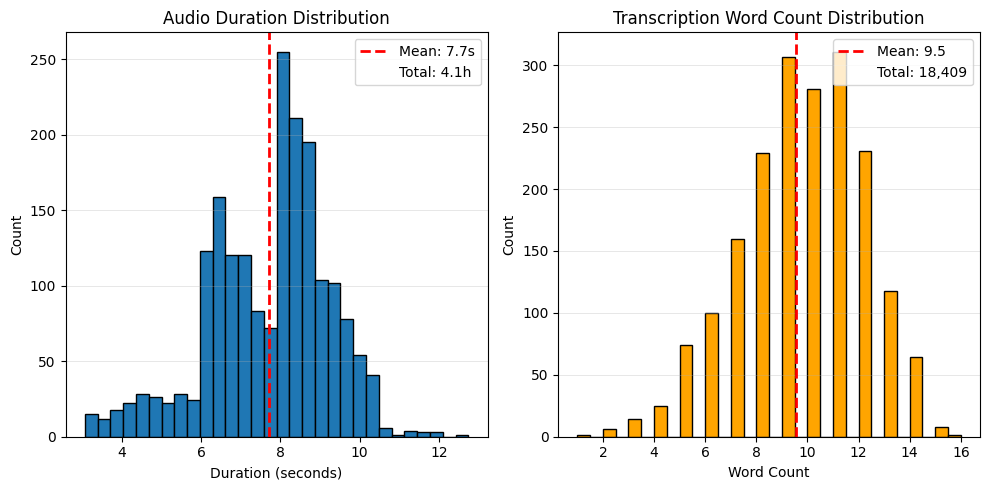

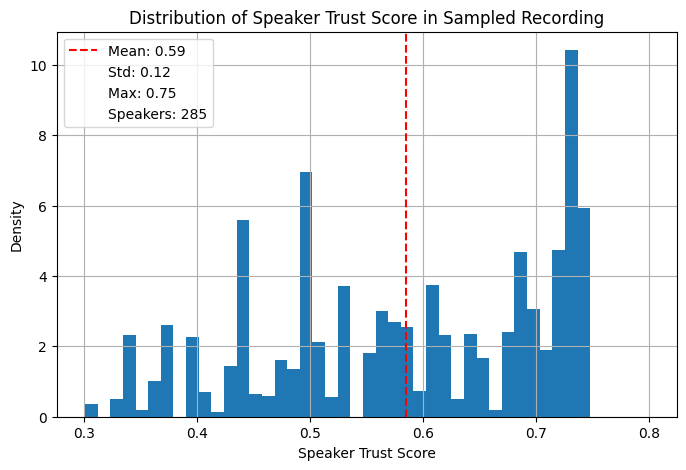

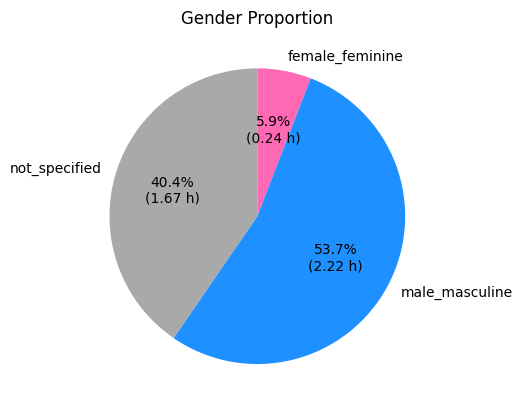

In [11]:
from scripts.dataset_plotting import plot_gender_pie_chart

plot_distribution_graphs(sampled_recordings)
plot_speaker_trust_score_distribution(sampled_recordings, data_frame_title="Sampled Recording")
plot_gender_pie_chart(sampled_recordings)

### Check sampled recording transcriptions with Google SPT